Random Forest algorithms represent a variant of Bagging applied to decision trees, with added randomness at the variable level.
In addition to the principle of Bagging which consists of building multiple trees on bootstrap data samples, random forests introduce a random selection of variables at each stage of tree construction.


How random forests work is relatively simple: many small classification trees are created on random subsets of the data.
Each decision tree is constructed by randomly selecting a sample of individuals from the training data, as well as a random subset of explanatory variables for each node in the tree.

Once the trees are built, the Random Forest method has them voted to determine the final classification. This voting step makes it possible to combine the predictions of these poorly correlated trees in order to determine the order and importance of the explanatory variables in the prediction.

In [9]:
import pandas as pd
import requests
import os.path
from sklearn import ensemble
from sklearn.model_selection import train_test_split
import pandas as pd
url = "https://raw.githubusercontent.com/harshbg/Telecom-Churn-Data-Analysis/master/Telecom%20Churn.csv"
filename = "telecom_churn.csv"

# Only download if file doesn't exist
if not os.path.exists(filename):
    response = requests.get(url)
    with open(filename, "wb") as f:
        f.write(response.content)

# Read the CSV file into a DataFrame
df = pd.read_csv(filename)
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [10]:
target = df['churn']

df = df.join(pd.get_dummies(df['international plan'], prefix='international'))
df = df.join(pd.get_dummies(df['voice mail plan'], prefix='voicemail'))

to_drop = ['international plan', 'voice mail plan', 'state', 'area code', 'phone number', 'churn']
data = df.drop(to_drop,axis=1)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=12)


In [11]:
clf = ensemble.RandomForestClassifier(n_jobs=-1, random_state=321)
clf.fit(X_train, y_train)


RandomForestClassifier(n_jobs=-1, random_state=321)

In [12]:
y_pred = clf.predict(X_test)
pd.crosstab(y_test, y_pred, rownames=['Real class'], colnames=['Predicted class'])


Predicted class,False,True
Real class,,
False,573,1
True,17,76


The confusion matrix above shows us that the model performs well in predicting customers who do not unsubscribe.
On the other hand, it has difficulty classifying customers who have indeed unsubscribed.

The model therefore does not have high performance at first glance in finding potential "churners", even if the model's rate of good predictions remains very good thanks to the small proportion of "churners" in the data.

In [13]:
clf.score(X_test, y_test)


0.9730134932533733

In [14]:
y_probas = clf.predict_proba(X_test)

n marketing, to promote a product, to retain a customer, or to prevent customers from unsubscribing to a service, there are what we call targeting campaigns.
The objective is to contact as few people as possible, while maximizing the number of customers who will respond positively to the operation.

In our example, the company wants to know which customers will unsubscribe in the near future, because it cannot contact all its customers, to offer them, for example, an offer to retain them.
One solution is therefore to create a model which returns a score (most often the probabilities of belonging to a class) for each individual, and to sort them in a decreasing manner according to this score. Thus the first 10% of customers thus classified are the 10% most likely to unsubscribe from the service.

A different way to evaluate the performance of our model is the creation of a cumulative gains curve. It allows you to know, thanks to the test sample, the percentage of "churners" that will be reached, depending on a chosen target size.

The plot_cumulative_gain() function of the metrics submodule of the scikitplot package allows you to display a cumulative gain curve very easily. You just need to give it as an argument the vector of the real labels of the test sample, and that of the predictions made by the model.

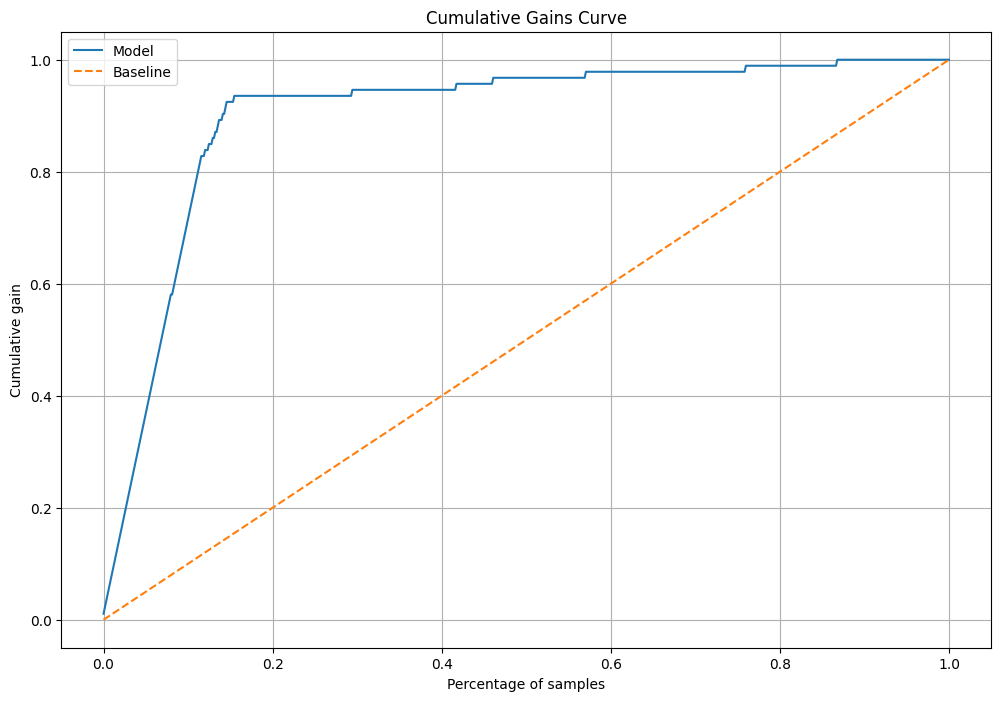

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cumulative_gain(y_true, y_prob):
    # Get the probabilities for the positive class
    pos_probs = y_prob[:, 1]
    
    # Sort by probability in descending order
    sorted_indices = np.argsort(pos_probs)[::-1]
    y_true_sorted = y_true[sorted_indices]
    
    # Calculate cumulative gains
    total_pos = np.sum(y_true)
    cum_gains = np.cumsum(y_true_sorted) / total_pos
    percentages = np.linspace(0, 1, len(y_true))
    
    # Plot
    plt.figure(figsize=(12, 8))
    plt.plot(percentages, cum_gains, label='Model')
    plt.plot([0, 1], [0, 1], '--', label='Baseline')
    plt.xlabel('Percentage of samples')
    plt.ylabel('Cumulative gain')
    plt.title('Cumulative Gains Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

# Use the function
plot_cumulative_gain(y_test.values, y_probas)

The horizontal axis represents the individuals in the test sample (667), the vertical axis the "churners" (95).

The curve shows that by targeting, for example, only the 20% of customers having obtained the best score by the model (i.e. the 20% of customers with the highest probability of unsubscribing), more than 90 % of future “churners” will thus be reached, whereas by selecting 20% of customers randomly, only 20% of “churners” will be reached.
This method makes it easier, and at a lower cost, to target customers/consumers likely to stop their subscription.

The cumulative gains curve is therefore a very useful tool for targeting operations, to reduce the costs of an operation and maximize yield.

To conclude, random forests are an extension of Bagging for decision trees, introducing randomness at the variable level. They combine multiple decision trees created on random subsets of the data and then vote them to determine the final classification.

This method reduces variance, improves model generalization, and provides a robust estimate of variable importance.

Random forests have multiple advantages over other classification models:

These are multi-class classification models, effective on high-dimensional data.

These are robust statistical methods for identifying aberrant values (outliers in English).

Generally speaking, they avoid overfitting, and do not require cross-validation thanks to "Out of bag" samples.

In addition, using the plot_cumulative_gain() function from the scikitplot package allows you to easily evaluate the performance of the model with a cumulative gain curve.

